In [6]:
from __future__ import annotations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sbn
from typing import Any, List, Type
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
from datetime import datetime
from sklearn.metrics import mean_squared_error
from timeseries import *

In [7]:
#df=pd.read_csv("ActonMay4.csv")
df = pd.read_csv('ActonMay4.csv', index_col=False, infer_datetime_format=True, parse_dates=[4, 5])

In [8]:
detector_sample=df["detector_id"].drop_duplicates().sample(10).to_numpy()

In [9]:
MA(df,'N25/011d2', 5)

188.33333333333334

In [10]:
MALD(df,"N24/012a1",24, 13)*24

1.5540348425339148

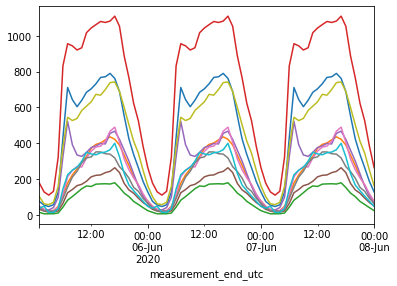

In [11]:
y=MALDforecast(df, 15, 3, display=True, detectors=detector_sample)

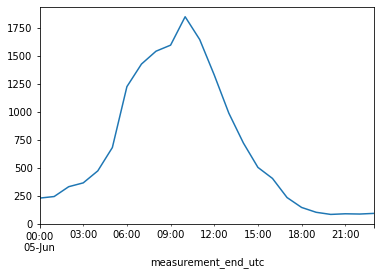

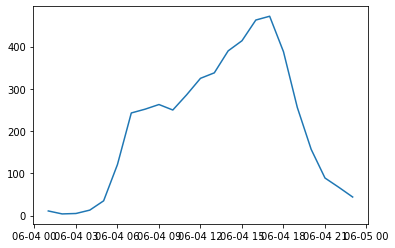

In [507]:
x=holt_winters(df, 15, 1, display=True, alpha=0.200983, beta= 0.05657496, gamma=0.69090398, detectors=detectors)
fig = plt.figure()
plt.plot(BD["measurement_end_utc"], BD["count"])

In [190]:
def baseline_MSE()
    
    

16805.221575927433
gradient= -0.016933552303580655


In [276]:
def gradient_decent(df, alpha=0.011964759098275513, beta=0.01322758270920145, gamma=0.29363083066992207):
    MSE=10000
    while(MSE>3700):
        step_vector=[0.001, 0.0013, 0.02]
        CBL=count_baseline(df, 20, 2, alpha=alpha, beta=beta, gamma=gamma)
        CBL=CBL.dropna()
        MSE=mean_squared_error(CBL["count"], CBL["baseline"])
        print(MSE)
        CBL=count_baseline(df, 20, 2, alpha=alpha+0.0001, beta=beta, gamma=gamma)
        CBL=CBL.dropna()
        MSE2=mean_squared_error(CBL["count"], CBL["baseline"])
        alpha_diff=MSE2-MSE
        CBL=count_baseline(df, 20, 2, alpha=alpha, beta=beta+0.0001, gamma=gamma)
        CBL=CBL.dropna()
        MSE2=mean_squared_error(CBL["count"], CBL["baseline"])
        beta_diff=MSE2-MSE
        CBL=count_baseline(df, 20, 2, alpha=alpha, beta=beta, gamma=gamma+0.0001)
        CBL=CBL.dropna()
        MSE2=mean_squared_error(CBL["count"], CBL["baseline"])
        gamma_diff=MSE2-MSE
        alpha = alpha - alpha_diff*step_vector[0]
        beta = beta - beta_diff*step_vector[1]
        gamma = gamma - gamma_diff*step_vector[2]
    
    print(alpha, beta, gamma)


In [506]:

from scipy.optimize import minimize

def baselineMSE(params):
    alpha=params[0]
    beta=params[1]
    gamma=params[2]
    CBL=count_baseline(df, 15, 2, alpha=alpha, beta=beta, gamma=gamma, detectors=detectors)
    CBL=CBL.dropna()
    return(mean_squared_error(CBL["count"], CBL["baseline"]))


ABY=[0.01, 0.05, 0.5]

optimum = minimize(baselineMSE, ABY, tol=10, method="Powell")
print(optimum)

C:\Users\t_tho\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:254: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,


   direc: array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])
     fun: 97203.6391973934
 message: 'Optimization terminated successfully.'
    nfev: 24
     nit: 1
  status: 0
 success: True
       x: array([0.200983  , 0.05657496, 0.69090398])


In [486]:
optimum

   direc: array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])
     fun: 46743.83295067703
 message: 'Optimization terminated successfully.'
    nfev: 34
     nit: 1
  status: 0
 success: True
       x: array([0.19247658, 0.10312133, 0.09766908])

In [12]:
CBL=count_baseline(df, 20, 2, alpha=0.011964759098275513, beta=0.01322758270920145, gamma=0.29363083066992207)

In [13]:
CBL=CBL.dropna()
mean_squared_error(CBL["count"], CBL["baseline"])

7365.77427745278

In [14]:
CB_plot(CBL)

NameError: name 'plt' is not defined

In [491]:
BD

,detector_id,lon,lat,measurement_start_utc,measurement_end_utc,baseline,Unnamed: 0,count
745,N25/010a3,-0.312013,51.488771,2020-06-04 00:00:00,2020-06-04 01:00:00,2207.440435,23722.0,11.0
746,N25/010a3,-0.312013,51.488771,2020-06-04 01:00:00,2020-06-04 02:00:00,2310.452966,23723.0,4.0
747,N25/010a3,-0.312013,51.488771,2020-06-04 02:00:00,2020-06-04 03:00:00,2111.847656,23724.0,5.0
748,N25/010a3,-0.312013,51.488771,2020-06-04 03:00:00,2020-06-04 04:00:00,1879.556069,23725.0,13.0
749,N25/010a3,-0.312013,51.488771,2020-06-04 04:00:00,2020-06-04 05:00:00,1482.700770,23726.0,35.0
750,N25/010a3,-0.312013,51.488771,2020-06-04 05:00:00,2020-06-04 06:00:00,1202.195693,23727.0,121.0
751,N25/010a3,-0.312013,51.488771,2020-06-04 06:00:00,2020-06-04 07:00:00,981.950635,23728.0,243.0
752,N25/010a3,-0.312013,51.488771,2020-06-04 07:00:00,2020-06-04 08:00:00,705.225801,23729.0,252.0
753,N25/010a3,-0.312013,51.488771,2020-06-04 08:00:00,2020-06-04 09:00:00,522.872936,23730.0,263.0
754,N25/010a3,-0.312013,51.488771,2020-06-04 09:00:00,2020-06-04 10:00:00,398.493331,23731.0,250.0


In [453]:
CBL["C/B"] = CBL["count"]/CBL["baseline"]
CBL["C-B"] = CBL["count"]-CBL["baseline"]

In [445]:
CBL["hour_from_start"]=CBL["measurement_end_utc"]-CBL["measurement_end_utc"].min()
CBL["hour_from_start"]=CBL["hour_from_start"].astype(dtype="timedelta64[h]")

In [446]:
detectors=["N25/010a3"]

In [489]:
BD=CBL[CBL["detector_id"]=="N25/010a3"]

In [490]:
fig = plt.figure(figsize=(20,10))
plt.plot(BD["measurement_end_utc"], BD["n_vehicles_in_interval"])
plt.plot(BD["measurement_end_utc"], BD["baseline"])


KeyError: 'n_vehicles_in_interval'

<Figure size 1440x720 with 0 Axes>

In [510]:
import matplotlib.colors as colors
offset=colors.DivergingNorm(vmin=0.5, vcenter=1, vmax=2)
offset

KeyError: 'hour_from_start'

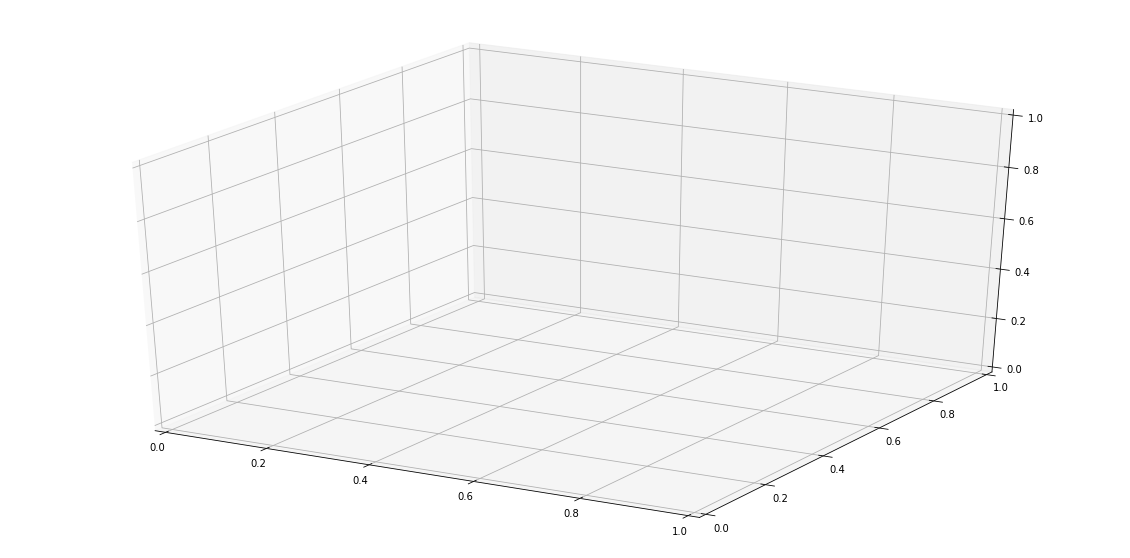

In [511]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
n = 100
p = ax.scatter( CBL["lat"], CBL["lon"], CBL['hour_from_start'], c=CBL['C/B'], s=CBL['count']*0.1, norm=offset, cmap="coolwarm")
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
fig.colorbar(p)
plt.show()

In [106]:
mean_squared_error(CBL["count"], CBL["baseline"])

4543.0930527599085

In [289]:
B=CBL[CBL["detector_id"]=="N24/012a1"]

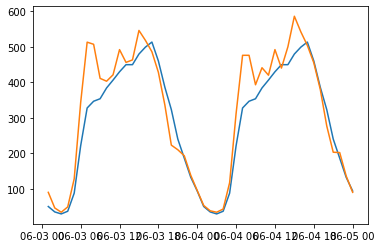

In [290]:
plt.plot(B["measurement_end_utc"], B["baseline"])
plt.plot(B["measurement_end_utc"], B["count"])

In [16]:
# def dataframe_org(df):
#     df2=df.sort_values(by=['measurement_end_utc'])
#     df2.index=pd.to_datetime(df2['measurement_end_utc'])
#     df2=df2.drop(["Unnamed: 0", "measurement_start_utc", "measurement_end_utc"], axis=1)
#     return df2
    
    

# def MA(df, detector, past_days):
#     one_D=df[df["detector_id"]==detector]
#     return(one_D.tail(n=24*past_days)['n_vehicles_in_interval'].mean())

# def MALD(df, detector, hour):
#     one_D=df[df["detector_id"]==detector]
#     hour=f'{hour:02}'
#     beta=(one_D.loc[one_D.index.strftime("%H") == hour]['n_vehicles_in_interval'].sum())/(one_D['n_vehicles_in_interval'].sum())
#     return beta

# def MAGD(df, hour):
#     hour=f'{hour:02}'
#     beta=(df.loc[df.index.strftime("%H") == hour]['n_vehicles_in_interval'].sum())/(df['n_vehicles_in_interval'].sum())
#     return beta

# def forecast(df, detectors, days_in_past, days_in_future, display=False):
#     framelist=[]
#     for detector in detectors:
#         meanV=MA(df, detector, days_in_past)
#         pred=[]
#         index=[]
#         for i in range(1, 24*days_in_future +1):
#             time=df.index[-1]+ np.timedelta64(i, 'h')
#             beta=MALD(df, detector, time.hour)
#             index.append(time)
#             pred.append(beta*24*meanV)

#         df2 = pd.DataFrame({"measurement_end_utc":index, "n_vehicles_in_interval": pred})
#         df2["detector_id"]=detector
#         df2["lon"] = df[df["detector_id"]==detector]["lon"][0]
#         df2["lat"] = df[df["detector_id"]==detector]["lat"][0]
        
#         framelist.append(df2)
#     DF=pd.concat(framelist)
#     DF=DF.set_index('measurement_end_utc')
    
#     if(display):
#         for detector in detectors:
#             DF[DF["detector_id"]==detector]["n_vehicles_in_interval"].plot()
    
#     return DF
        
    

In [508]:
def CB(
    df: pd.DataFrame,
    days_in_past: int,
    days_in_future: int,
    detectors: list = None,
    alpha=0.06,
    beta=0.02,
    gamma=0.6,
):

    """Produces a DataFrame where the count and baseline can be compared for use
        in scan statistics

    Args: 
        df: Dataframe of SCOOT data
        detectors: List of detectors to look at
        days_in_past: Integer past days to train forecast one
        days_in_future: Days in future produce a baseline too and record count for
        method: Forecast method to use for baseline, default is "HW" for Holt-Winters, option for MLAD

    Returns:
        Dataframe of counts and baseline along with detector data

        """

    if detectors is None:
        detectors = df["detector_id"].drop_duplicates().to_numpy()

    prediction_start = df["measurement_end_utc"].iloc[-1] - np.timedelta64(
        days_in_future * 24, "h"
    )

    train_data = df[df["measurement_end_utc"] <= prediction_start]
    test_data = df[df["measurement_end_utc"] > prediction_start]
    y = holt_winters(
        train_data,
        days_in_past,
        days_in_future,
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        detectors=detectors,
    )
    
    sd = []

    for detector in detectors:

        sd.append(test_data[test_data["detector_id"] == detector])

    sample_test_data = pd.concat(sd)

    Y = y.merge(
        sample_test_data,
        on=[
            "lon",
            "lat",
            "measurement_end_utc",
            "detector_id",
            "measurement_start_utc",
        ]
    )
    Y = Y.rename(
        columns={
            "n_vehicles_in_interval_x": "baseline",
            "n_vehicles_in_interval_y": "count",
        }
    )

    return Y